# Stix Dispersion Solver

[stix]: ../../api_static/plasmapy.dispersion.analytical.stix_.rst
[bellan2012]: https://doi.org/10.1029/2012JA017856
[stix1992]: https://link.springer.com/book/9780883188590

This notebook details the functionality of the [stix()][stix] function. This is an analytical solution of equation 8 in [Bellan 2012][bellan2012], the function is defined by Stix [1992] in section 1-3 to be:

$$
        (S\sin^{2}(\theta) + P\cos^{2}(\theta))(ck/\omega)^{4}
            - [
                RL\sin^{2}(\theta) + PS(1 + \cos^{2}(\theta))
            ](ck/\omega)^{2} + PRL = 0
$$

where,

$$
        \mathbf{B_o} = B_{o} \mathbf{\hat{z}}   
         \cos \theta = \frac{k_z}{k} \\
        \mathbf{k} = k_{\rm x} \hat{x} + k_{\rm z} \hat{z}
$$

$$
        S = 1 - \sum_{s} \frac{\omega^{2}_{p,s}}{\omega^{2} -
            \omega^{2}_{c,s}}\hspace{2.5cm}
        P = 1 - \sum_{s} \frac{\omega^{2}_{p,s}}{\omega^{2}}\hspace{2.5cm}
        D = \sum_{s}
            \frac{\omega_{c,s}}{\omega}
            \frac{\omega^{2}_{p,s}}{\omega^{2} -
            \omega_{c,s}^{2}}
$$

$$
        R = S + D \hspace{1cm} L = S - D
$$

$\omega$ is the wave frequency, $k$ is the wavenumber, $\theta$ is the wave propagation angle with respect to the background magntic field $\mathbf{B_o}$, $s$ corresponds to plasma species $s$, $\omega_{p,s}$ is the plasma frequency of species $s$, and $\omega_{c,s}$ is the gyrofrequency of species $s$.

<div class="alert alert-info">
Note

The derivation of this dispersion relation assumed:
    
 * zero temperature for all plasma species ($T_{s}=0$)
 * quasi-neutrallity
 * a uniform background magntic field $\mathbf{B_o} = B_{o} \mathbf{\hat{z}}$
 * no D.C. electric field $\mathbf{E_o}=0$
 * zero-order quantities for all plasma parameters (densities, electric-field, magnetic field, particle speeds, etc.) are constant in time and space
 * first-order perturbations in plasma parameters vary like $\sim e^{\left [ i (\textbf{k}\cdot\textbf{r} - \omega t)\right ]}$
    
</div>  

Due to the cold plasma assumption, this equation is valid for all $\omega$ and $k$ given $\frac{\omega}{k_{z}} \gg v_{Th}$ for all thermal speeds $v_{Th}$ of all plasma species and $k_{x} r_{L} \ll 1$ for all gyroradii $r_{L}$ of all plasma species. The relation predicts $k \to 0$ when any one of P, R or L vanish (cutoffs) and $k \to \infty$ for perpendicular propagation during wave resonance $S \to 0$.
 

## Contents

1. [Wave Normal to the Surface](#Wave-normal-to-the-surface)
2. [Comparison with Bellan](#Comparison-with-bellan)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u
from astropy.constants import eps0
from astropy.constants.si import c

from plasmapy.dispersion.analytical.stix_ import stix
from plasmapy.dispersion.analytical.two_fluid_ import two_fluid
from plasmapy.formulary import speeds
from plasmapy.formulary.frequencies import gyrofrequency, plasma_frequency
from plasmapy.formulary.lengths import inertial_length
from plasmapy.particles import Particle

## Wave Normal to the Surface

Below we define the required parameters to compute the wave numbers.

In [2]:
# define input parameters
inputs_1 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": Particle("p"),
    "n_i": 2.0e12 * u.cm**-3,
    "B": 0.43463 * np.sqrt(2) * u.T,
    "w": 500000 * 2 * np.pi * u.rad / u.s,
}

# define a meshgrid based on the number of theta values
omegas, thetas = np.meshgrid(
    inputs_1["w"].value, inputs_1["theta"].value, indexing="ij"
)
omegas = np.dstack((omegas,) * 4).squeeze()
thetas = np.dstack((thetas,) * 4).squeeze()

# compute k values
k = stix(**inputs_1)

[Quantity]: https://docs.astropy.org/en/stable/api/astropy.units.Quantity.html#astropy.units.Quantity

The computed wavenubmers in units (rad/m) are returned in a dictionary (shape $N \times M \times 4$), with the keys representing $\theta$ and the values (instances of Astropy [Quantity]) being the wavenumbers. The first dimension maps to the $w$ array, the second dimension maps to the $theta$ array, and the third dimension maps to the four roots of the Stix polynomial.
* $k[0]$ is the square root of the positive quadratic solution
* $k[1] = -k[0]$
* $k[2]$ is the square root of the negative quadratic solution
* $k[3] = -k[2]$

Below the values for $u_{x}$ and $u_{z}$ are calculated.

In [3]:
# calculate ux and uz

u_v = {}

mask = np.imag(k) == 0

va = speeds.va_(inputs_1["B"], inputs_1["n_i"], ion=inputs_1["ions"])
for arr in k:
    val = 0
    for item in arr:
        val = val + item**2
    norm = (np.sqrt(val)*va/inputs_1["w"]).value**2
    u_v = {
        "ux": norm * omegas[mask] * np.sin(thetas[mask]) / (k.value[mask] * c.value),
        "uz": norm * omegas[mask] * np.cos(thetas[mask]) / (k.value[mask] * c.value),
    }



Let's plot the results.

/Users/elliotjohnson/opt/anaconda3/envs/test/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


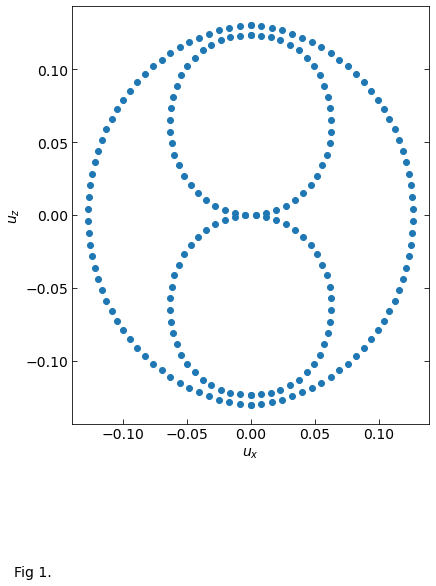

In [4]:
# plotting the results

fs = 14  # default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

plt.scatter(u_v['ux'], u_v['uz'])

# adjust axes
plt.xlabel(r"$u_{x}$", fontsize=fs)
plt.ylabel(r"$u_{z}$", fontsize=fs)

plt.tick_params(
    which="both",
    direction="in",
    labelsize=fs,
    right=True,
    length=5,
)

# plot caption
txt = "Fig 1. "

plt.figtext(0, -0.15, txt, ha="left", fontsize=fs)

plt.show()

Following on, the figures from Stix [1992] can be reproduced.

<Figure size 432x288 with 0 Axes>

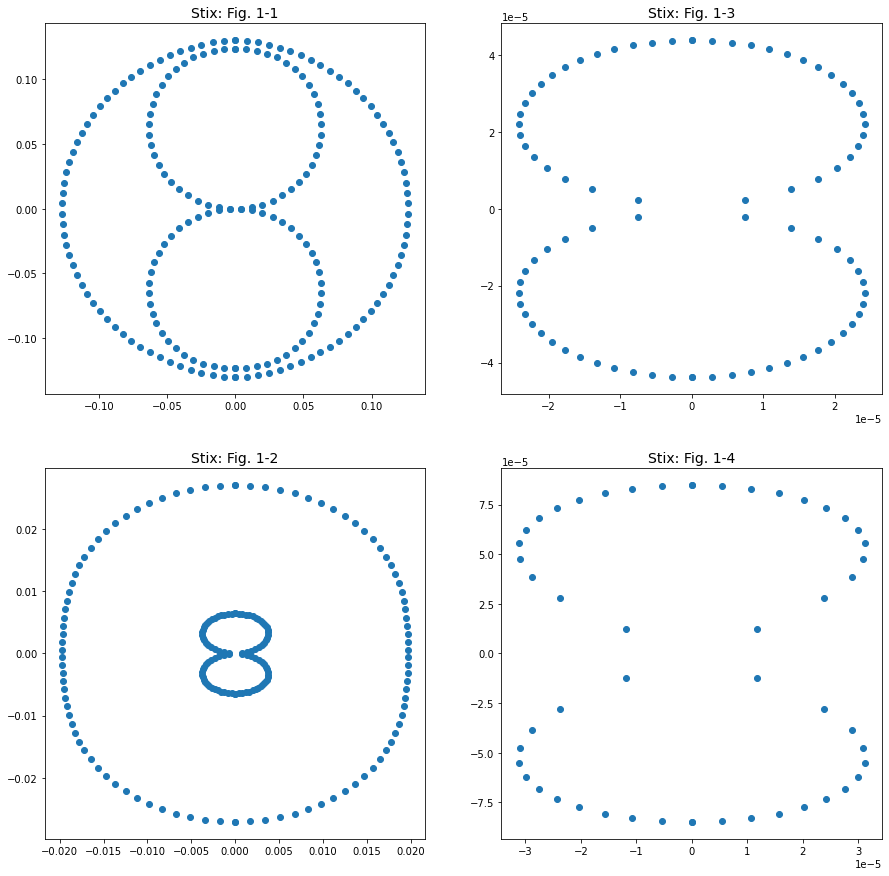

In [5]:
# define inputs
inputs_2 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": Particle("p"),
    "n_i": 1e15 * u.cm**-3,
    "B": 0.434 * u.T,
    "w": (37125810) * u.rad / u.s,
}

inputs_3 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": Particle("p"),
    "n_i": 1e15 * u.cm**-3,
    "B": 0.434534 * u.T,
    "w": (2 * 10**10) * u.rad / u.s,
}


inputs_4 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": Particle("p"),
    "n_i": 1e15 * u.cm**-3,
    "B": 0.434600 * u.T,
    "w": (54 * 10**9) * u.rad / u.s,
}


inputs_5 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": Particle("p"),
    "n_i": 1e15 * u.cm**-3,
    "B": 0.434634 * u.T,
    "w": (58 * 10**7) * u.rad / u.s,
}

names = [1, 2, 3, 4, 5]
inputs = [inputs_1, inputs_2, inputs_3, inputs_4, inputs_5]

stix_plt={}

ux={}
uz={}

for name in names:
    stix_plt[name] = {}


for i, inpt in enumerate(inputs):
    omegas, thetas = np.meshgrid(inpt["w"].value, inpt["theta"].value, indexing="ij")
    omegas = np.dstack((omegas,) * 4).squeeze()
    thetas = np.dstack((thetas,) * 4).squeeze()

    k = stix(**inpt)
    
    mask = np.imag(k) == 0
    
    va = speeds.va_(inpt["B"], inpt["n_i"], ion=inpt["ions"])
    
    for arr in k:
        val = 0
        for item in arr:
            val = val + item**2
        norm = (np.sqrt(val)*va/inpt["w"]).value**2
        stix_plt[names[i]] = {
            "ux": norm * omegas[mask] * np.sin(thetas[mask]) / (k.value[mask] * c.value),
            "uz": norm * omegas[mask] * np.cos(thetas[mask]) / (k.value[mask] * c.value),
        }


fs = 14  # default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure()
fig, axs = plt.subplots(2, 2, figsize=[15, 15])


for i in range(2):
    for j in range(2):
        axs[i, j].scatter(stix_plt[i + 2*j + 1]['ux'], stix_plt[i + 2*j + 1]['uz'])
        axs[i, j].set_title("Stix: Fig. 1-" + str(i + 2*j + 1), fontsize=fs)
plt.show()

## Comparison with Bellan

Below we run a Comparison between the solution provided in Bellan [2012] and our own solutions computed from [stix()][stix]. To begin we first have to define some parameter.

In the first instance a cold plasma limit of $T_{e} = \, {\rm K}$ and $T_{H+} = \, {\rm K}$ are assumed. In the second instance a warm plasma limit of $T_{e} = \, {\rm K}$ and $T_{H+} = \, {\rm K}$ are assumed.

In [6]:
# define new inputs for Hot and Cold

w = inputs_2["w"].value

inputs_H = {
    "theta": np.linspace(0, np.pi / 2, 50) * u.rad,
    "ion": Particle("p"),
    "n_i": 1.0e15 * u.cm**-3,
    "B": 0.434634 * u.T,
    "k": (w / c.value) * u.rad / u.m,
    "T_e": 1e6 * u.K,
    "T_i": 1e6 * u.K,
}

inputs_C = {
    "theta": np.linspace(0, np.pi / 2, 50) * u.rad,
    "ion": Particle("p"),
    "n_i": 1.0e15 * u.cm**-3,
    "B": 0.434634 * u.T,
    "k": (w / c.value) * u.rad / u.m,
    "T_e": 1000 * u.K,
    "T_i": 1000 * u.K,
}

names = ["Hot", "Cold"]
inpts = [inputs_H, inputs_C]

two_fluid_plt = {}

for name in names:
    two_fluid_plt[name] = {}


for i, inpt in enumerate(inpts):
    k, thetas = np.meshgrid(inpt["k"].value, inpt["theta"].value, indexing="ij")

    omegas = two_fluid(**inpt)

    va = speeds.va_(inpt["B"], inpt["n_i"], ion=inpt["ion"])

    for mode, arr in omegas.items():
        norm = (np.absolute(arr) / (k * va)).value ** 2
        two_fluid_plt[names[i]][mode] = {
            "x": norm * np.sin(inpt["theta"].to(u.rad).value),
            "y": norm * np.cos(inpt["theta"].to(u.rad).value),
        }
        
    #(do same here for stix to renorm)

/Users/elliotjohnson/opt/anaconda3/envs/test/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


<Figure size 432x288 with 0 Axes>

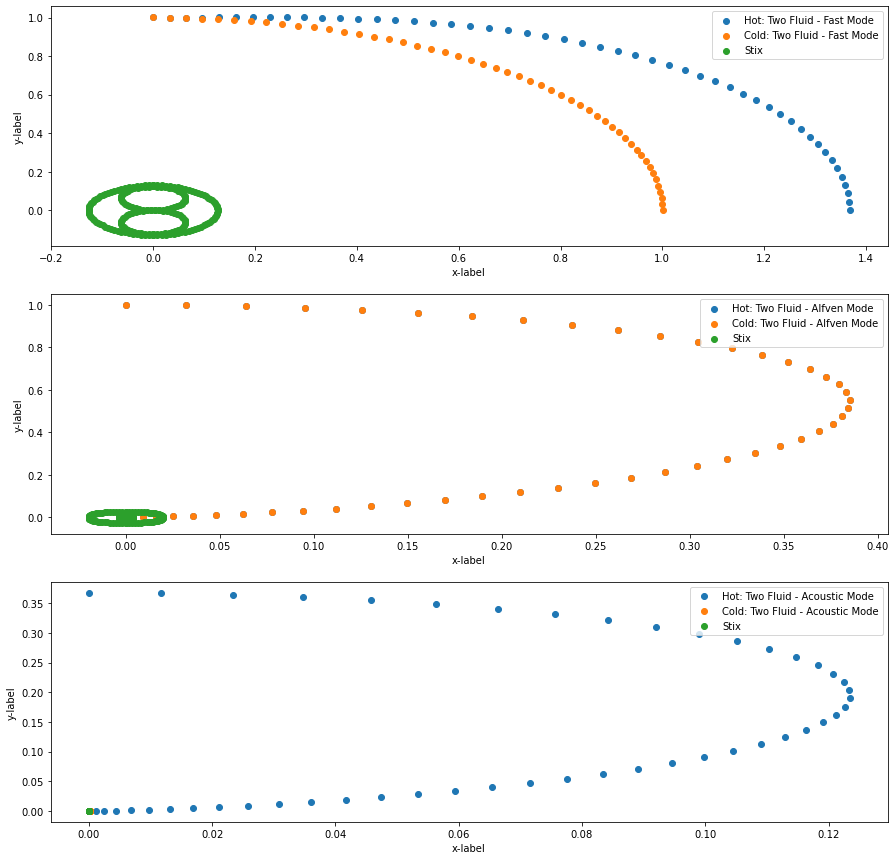

In [7]:
# plot the results

figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure()
fig, axs = plt.subplots(3, 1, figsize=[15, 15])

for name in names:
    j = 0
    for mode, vals in two_fluid_plt[name].items():
        arg_lab = (
            name
            + ": Two Fluid - "
            + str(mode).split("_")[0].capitalize()
            + " "
            + str(mode).split("_")[1].capitalize()
        )
        axs[j].scatter(vals["x"], vals["y"], label=arg_lab)
        axs[j].set(xlabel="x-label", ylabel="y-label")
        j = j + 1


for i in range(3):
    axs[i].scatter(stix_plt[i + 1]['ux'], stix_plt[i + 1]['uz'], label="Stix")
    axs[i].legend(loc="upper right")


plt.show()